# リポジトリクローン

In [ ]:
!git clone https://github.com/albrateanu/LYT-Net

In [ ]:
%cd LYT-Net

# 重みダウンロード

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=1PgmxATX6JeP6_ygpSR2jJdzQNuSB2_Cn', 'LOLv1.h5', quiet=False)
gdown.download('https://drive.google.com/uc?id=1sqISc3Bup9WDpv9hwA91FAo8AsNfLABg', 'LOLv2_Real.h5', quiet=False)
gdown.download('https://drive.google.com/uc?id=1zGy5i5WFGbiDhYtSAghu5u-v-dZxZki4', 'LOLv2_Synthetic.h5', quiet=False)

# テストデータダウンロード

In [ ]:
import gdown

!mkdir data

gdown.download('https://drive.google.com/uc?id=1vhJg75hIpYvsmryyaxdygAWeHuiY_HWu', 'LOLv1.zip', quiet=False)
!unzip LOLv1.zip
!mv LOLv1 data

# gdown.download('https://drive.google.com/uc?id=1OMfP6Ks2QKJcru1wS2eP629PgvKqF2Tw', 'LOLv2.zip', quiet=False)
# !unzip LOLv2.zip
# !mv LOLv2 data

# ONNX変換

In [ ]:
!pip install -U tf2onnx onnx onnxsim onnxruntime

In [62]:
import os
import shutil

import cv2
import numpy as np

from model.arch import LYT, Denoiser

def convert_to_onnx(
    model_path,
    input_shape=(640, 360),
    onnx_filename='output.onnx',
):
    # モデル構築
    denoiser_cb = Denoiser(16)
    denoiser_cr = Denoiser(16)
    denoiser_cb.build(input_shape=(None, None, None, 1))
    denoiser_cr.build(input_shape=(None, None, None, 1))
    model = LYT(filters=32, denoiser_cb=denoiser_cb, denoiser_cr=denoiser_cr)
    model.build(input_shape=(None, None, None, 3))

    # 重みロード
    model.load_weights(f'{model_path}')

    # ダミー入力での実行
    dummy_input = np.zeros((input_shape[1], input_shape[0], 3), np.float32)
    dummy_input = dummy_input.reshape(1, input_shape[1], input_shape[0], 3)
    _ = model(dummy_input)

    # チェックポイント保存
    temp_checkpoint_path = 'temp_checkpoint'
    if os.path.exists(temp_checkpoint_path):
        shutil.rmtree(temp_checkpoint_path)
    model.save(temp_checkpoint_path)

    # ONNX変換
    !python -m tf2onnx.convert --opset 16 \
        --saved-model $temp_checkpoint_path \
        --output $onnx_filename

    !onnxsim $onnx_filename $onnx_filename

In [ ]:
convert_to_onnx(model_path='LOLv1.h5', input_shape=(320, 240), onnx_filename='lyt_net_lolv1_320x240.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv1.h5', input_shape=(640, 360), onnx_filename='lyt_net_lolv1_640x360.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv1.h5', input_shape=(800, 400), onnx_filename='lyt_net_lolv1_800x400.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv2_Real.h5', input_shape=(320, 240), onnx_filename='lyt_net_lolv2_real_320x240.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv2_Real.h5', input_shape=(640, 360), onnx_filename='lyt_net_lolv2_real_640x360.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv2_Real.h5', input_shape=(800, 400), onnx_filename='lyt_net_lolv2_real_800x400.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv2_Synthetic.h5', input_shape=(320, 240), onnx_filename='lyt_net_lolv2_synthetic_320x240.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv2_Synthetic.h5', input_shape=(640, 360), onnx_filename='lyt_net_lolv2_synthetic_640x360.onnx')

In [ ]:
convert_to_onnx(model_path='LOLv2_Synthetic.h5', input_shape=(800, 400), onnx_filename='lyt_net_lolv2_synthetic_800x400.onnx')

# ONNX推論テスト

In [ ]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession(
    'lyt_net_lolv1_640x360.onnx',
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
)

input_detail = onnx_session.get_inputs()[0]
input_name = input_detail.name
output_name = onnx_session.get_outputs()[0].name

model_input_shape = input_detail.shape[1:3]
print(model_input_shape)

In [73]:
import cv2
image = cv2.imread('/content/LYT-Net/data/LOLv1/Test/input/1.png')

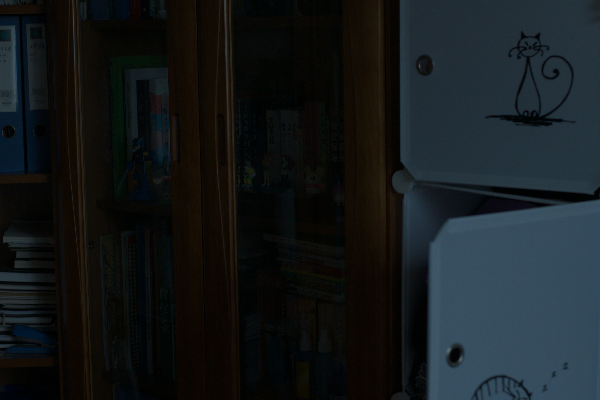

In [74]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [75]:
%%time

import cv2
import numpy as np

# 前処理
input_image = cv2.resize(image, dsize=(model_input_shape[1], model_input_shape[0]))
input_image = (input_image / 255.0) * 2 - 1.0
input_image = input_image.astype('float32')

# NHWCへリシェイプ
input_image = input_image.reshape(1, model_input_shape[0], model_input_shape[1], 3)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: input_image})

# 後処理
onnx_result = np.array(onnx_result[0]).squeeze()
generated_image = (((onnx_result + 1.0) / 2.0) * 255).astype('uint8')
generated_image = cv2.resize(generated_image, dsize=(image.shape[1], image.shape[0]))

CPU times: user 2.19 s, sys: 395 ms, total: 2.58 s
Wall time: 659 ms


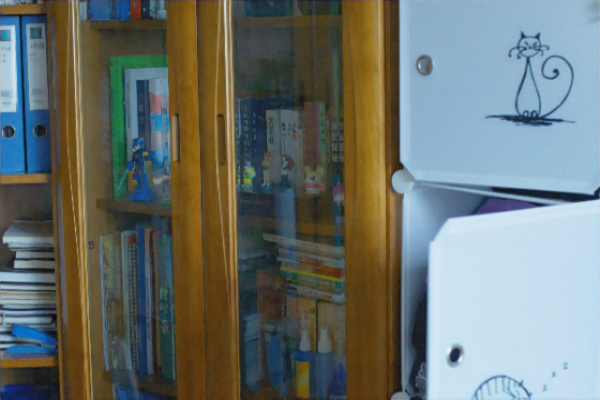

In [76]:
from google.colab.patches import cv2_imshow
cv2_imshow(generated_image)